In [1]:
import UsersAllocation
import pandas as pd

In [2]:
bs = pd.read_csv("./datasets/BS.csv")

In [3]:
# Number of users to generate
tot_users = 100

# Getting max bs x and y
max_x, max_y = bs.x.max(), bs.y.max()

# IoT users percent (of totUsers)
iot_users_percent = 0.8

user_gen_order = UsersAllocation.UserGenOrder.SHUFFLE

# Generating users in random locations
users = UsersAllocation.generateUsers(max_x, max_y, tot_users, iot_users_percent, user_gen_order)

users.head(tot_users)

Generated 80 IoT users and 20 MMB users


,x,y,type
0,183.744452,229.280846,iot
1,243.416804,212.994454,iot
2,292.245557,182.571889,mmb
3,111.232342,271.316960,iot
4,205.758603,79.158445,iot
5,50.944789,7.746654,iot
6,230.171753,298.340337,iot
7,298.998576,299.164198,iot
8,19.215416,166.773183,iot
9,109.581072,6.915750,iot


In [4]:
print('Max MMB user bit rate is', UsersAllocation.mmbUser.get_bit_rate(), '[Mbit/s]')
print('Max IoT user bit rate is', UsersAllocation.iotUser.get_bit_rate(), '[Mbit/s]')

Max MMB user bit rate is 1.0831640625000003 [Mbit/s]
Max IoT user bit rate is 0.10350234375000002 [Mbit/s]


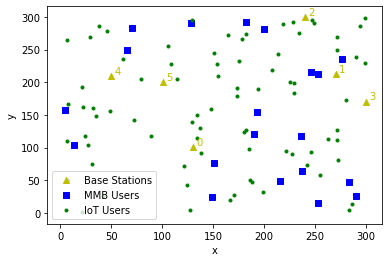

In [5]:
UsersAllocation.plotPositions(bs, users)

In [6]:
pathLosses = UsersAllocation.compute_path_losses(bs, users)
    
pathLosses.head(tot_users*bs.shape[0])

,bsIdx,uIdx,type,pathLoss
0,0,0,iot,103.420851
1,1,0,iot,90.973673
2,2,0,iot,102.094580
3,3,0,iot,95.795229
4,4,0,iot,107.784099
5,5,0,iot,103.417144
6,0,1,iot,106.605861
7,1,1,iot,94.438908
8,2,1,iot,94.030865
9,3,1,iot,101.722393


In [7]:
min_path_loss_connections = UsersAllocation.compute_min_path_losses_connections(bs, pathLosses)

min_path_loss_connections.head(tot_users)        

,uIdx,bsIdx,type,pathLoss,bitRate
0,0,1,iot,90.973673,0
1,1,2,iot,94.030865,0
2,2,2,mmb,92.992038,1
3,3,3,iot,94.602674,0
4,4,5,iot,80.520833,0
5,5,0,iot,103.670282,0
6,6,1,iot,85.756756,0
7,7,2,iot,93.164421,0
8,8,0,iot,98.485967,0
9,9,4,iot,101.223863,0


Network bit rate is 12 [Mbit/s]
Users disconnected: 46.0 %


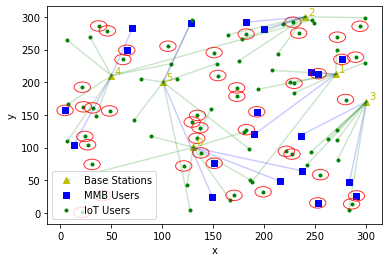

In [8]:
# Getting the min path loss solution
min_path_loss_solution = UsersAllocation.evaluate_solution(min_path_loss_connections, tot_users)

print('Network bit rate is', min_path_loss_solution['tot_bit_rate'], '[Mbit/s]')
print('Users disconnected:', min_path_loss_solution['disc_users_percent'], '%')

# Plotting users/base stations and related minimum path loss connection
UsersAllocation.plotPositions(bs, users, min_path_loss_connections)

In [9]:
geneticAllocation = UsersAllocation.GeneticAllocation(bs, users)

geneticAllocation.generate_population(200)

print(geneticAllocation.population)

{0:    bsIdx uIdx type   bitRate
0      5    0  iot  0.103502
1      5    1  iot  0.103502
2      0    2  mmb   1.08316
3      0    3  iot  0.103502
4      3    4  iot  0.103502
5      1    5  iot  0.103502
6      1    6  iot  0.103502
7      2    7  iot  0.103502
8      3    8  iot  0.103502
9      0    9  iot  0.103502
10     3   10  iot  0.103502
11     5   11  iot  0.103502
12     0   12  iot  0.103502
13     2   13  iot  0.103502
14     4   14  iot  0.103502
15     5   15  iot  0.103502
16     0   16  iot  0.103502
17     5   17  mmb   1.08316
18     5   18  iot  0.103502
19     1   19  iot  0.103502
20     4   20  iot  0.103502
21     4   21  mmb   1.08316
22     1   22  iot  0.103502
23     1   23  iot  0.103502
24     4   24  iot  0.103502
25     2   25  mmb   1.08316
26     2   26  mmb   1.08316
27     4   27  iot  0.103502
28     5   28  iot  0.103502
29     1   29  iot  0.103502
..   ...  ...  ...       ...
70  None   70  iot         0
71  None   71  iot         0
72  None  

In [10]:
first_best_fitness, second_best_fitness = geneticAllocation.fitness()

Network bit rate is 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %


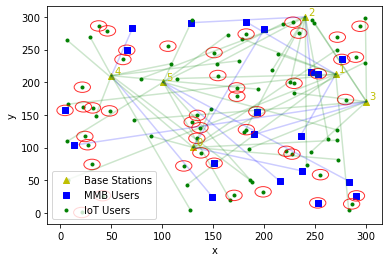

In [11]:
# Getting first fitness solution
first_fitness_solution = UsersAllocation.evaluate_solution(first_best_fitness, tot_users)

print('Network bit rate is', first_fitness_solution['tot_bit_rate'], '[Mbit/s]')
print('Users disconnected:', first_fitness_solution['disc_users_percent'], '%')

# Plotting users/base stations and related first best fitness solution
UsersAllocation.plotPositions(bs, users, first_best_fitness)

Network bit rate is 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %


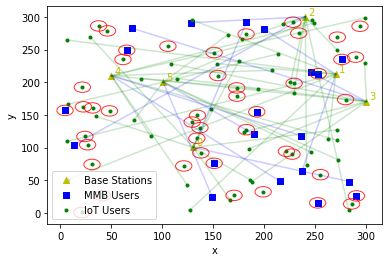

In [12]:
# Getting second fitness solution
second_fitness_solution = UsersAllocation.evaluate_solution(second_best_fitness, tot_users)

print('Network bit rate is', second_fitness_solution['tot_bit_rate'], '[Mbit/s]')
print('Users disconnected:', second_fitness_solution['disc_users_percent'], '%')

# Plotting users/base stations and related second best fitness solution
UsersAllocation.plotPositions(bs, users, second_best_fitness)

In [13]:
geneticAllocation2 = UsersAllocation.GeneticAllocation(bs, users)

geneticAllocation2.genetic_evolution()

Generation: 1 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 2 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 3 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 4 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 5 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 6 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 7 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 8 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 9 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %
Generation: 10 results
Total bit rate: 17.3450671875 [Mbit/s]
Users disconnected: 46.0 %


,bsIdx,uIdx,type,bitRate
0,0,0,iot,0.103502
1,0,1,iot,0.103502
2,3,2,mmb,1.08316
3,4,3,iot,0.103502
4,4,4,iot,0.103502
5,3,5,iot,0.103502
6,1,6,iot,0.103502
7,0,7,iot,0.103502
8,2,8,iot,0.103502
9,1,9,iot,0.103502
